In [1]:
import json
import math
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import helper

# Business

## Lobbying
Data from [OpenSecrets](https://www.opensecrets.org/federal-lobbying/industries?cycle=2023)

In [2]:
lobbying_by_industry = pd.DataFrame()

for file_name in glob.iglob("../raw_data/business/lobbying/*.csv"):
    industries_for_year = pd.read_csv(file_name)
    year_string = file_name.replace(".csv", "").split("_")[-1]
    industries_for_year["Year"] = int(year_string)

    lobbying_by_industry = pd.concat([lobbying_by_industry, industries_for_year])

# Replace industry names
lobbying_by_industry["Industry"] = lobbying_by_industry.Industry.str.replace("Pharmaceuticals/Health Products", "Medical")
lobbying_by_industry["Industry"] = lobbying_by_industry.Industry.str.replace("Electronics Mfg & Equip", "Computers")

lobbying_by_industry["Total"] = lobbying_by_industry.Total.str.replace("$", "")
lobbying_by_industry["Total"] = pd.to_numeric(lobbying_by_industry.Total) / 1_000_000

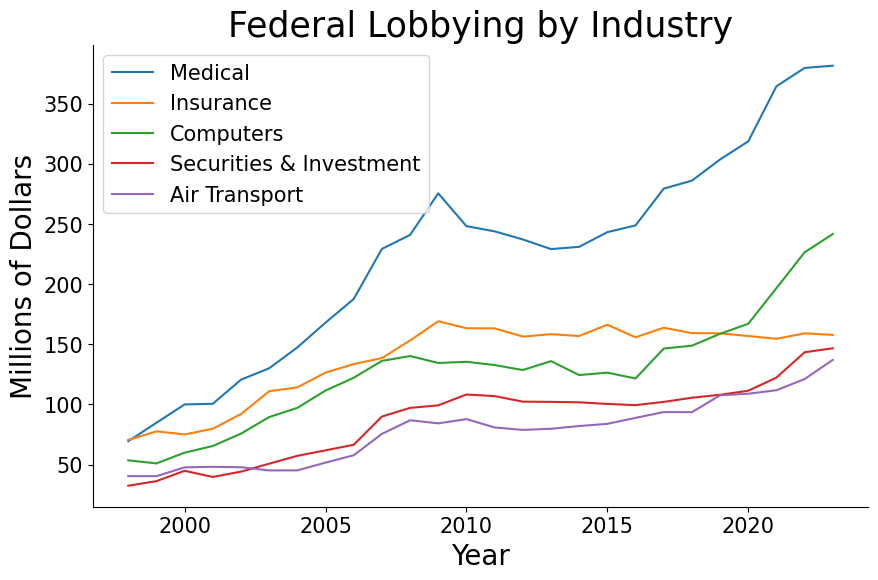

In [3]:
highest_industries = lobbying_by_industry[lobbying_by_industry.Year == 2023].sort_values(by="Total").Industry.values[-5:]

sns.lineplot(x="Year", y="Total", data=lobbying_by_industry[lobbying_by_industry.Industry.isin(highest_industries)], hue="Industry")

plt.ylabel("Millions of Dollars")
plt.legend(title="")
plt.title("Federal Lobbying by Industry")

plt.savefig("../images/federal_lobbying_by_industry.png")

## Total factor productivity (TFP)

Data from [SF Federal Reserve](https://www.frbsf.org/research-and-insights/data-and-indicators/total-factor-productivity-tfp/)

In [4]:
tfp = pd.read_csv("../raw_data/tfp.txt")
tfp["Date"] = pd.to_datetime(tfp["Date"], format="mixed")

Text(0.5, 0, 'Year')

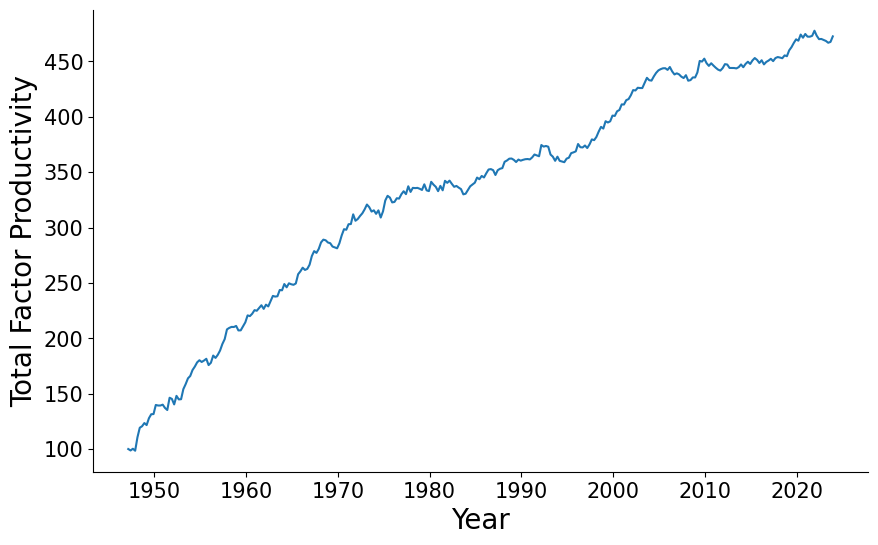

In [5]:
data = np.copy(tfp.dtfp_util.values)
data[0] = 100
tfp["UA_TFP"] = np.cumsum(data)

sns.lineplot(x="Date", y="UA_TFP", data=tfp)
plt.ylabel("Total Factor Productivity")
plt.xlabel("Year")

## Financialization

In [6]:
stock_buybacks = pd.read_csv("../raw_data/business/financialization/stock_buybacks.csv")
stock_buybacks["Date"] = pd.to_datetime(stock_buybacks["Date"])

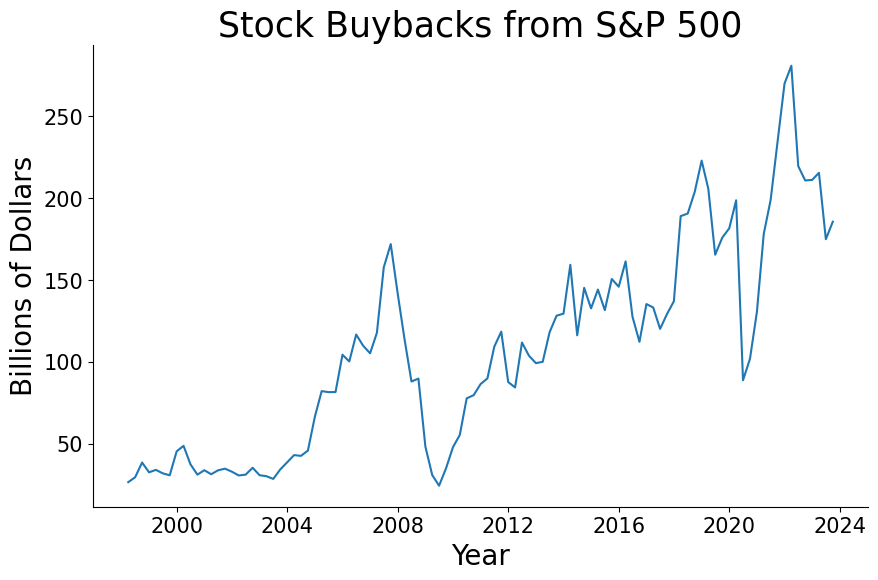

In [7]:
sns.lineplot(x="Date", y="Buybacks (Billions of Dollars)", data=stock_buybacks)
plt.ylabel("Billions of Dollars")
plt.xlabel("Year")
plt.title("Stock Buybacks from S&P 500")

plt.savefig("../images/stock_buybacks.png")

## Manufacturing

Raw data pulled from [here](https://unstats.un.org/unsd/snaama/Downloads)

In [8]:
df = pd.read_excel("../raw_data/business/GDPcurrent-USD-countries.xlsx", header=2).drop(columns=["CountryID"])
manufacturing = df[df["IndicatorName"] == "Manufacturing (ISIC D)"].drop(columns=["IndicatorName"])
manufacturing = pd.melt(manufacturing, id_vars=["Country"], var_name="Year", value_name="Value")

manufacturing.groupby("Country").max().reset_index().sort_values(by="Value").tail(5)

,Country,Year,Value
157,Republic of Korea,2022,4.634545e+11
78,Germany,2022,8.090322e+11
99,Japan,2022,1.301642e+12
207,United States,2022,2.649697e+12
40,China,2022,5.063209e+12


<AxesSubplot:xlabel='Year', ylabel='Value'>

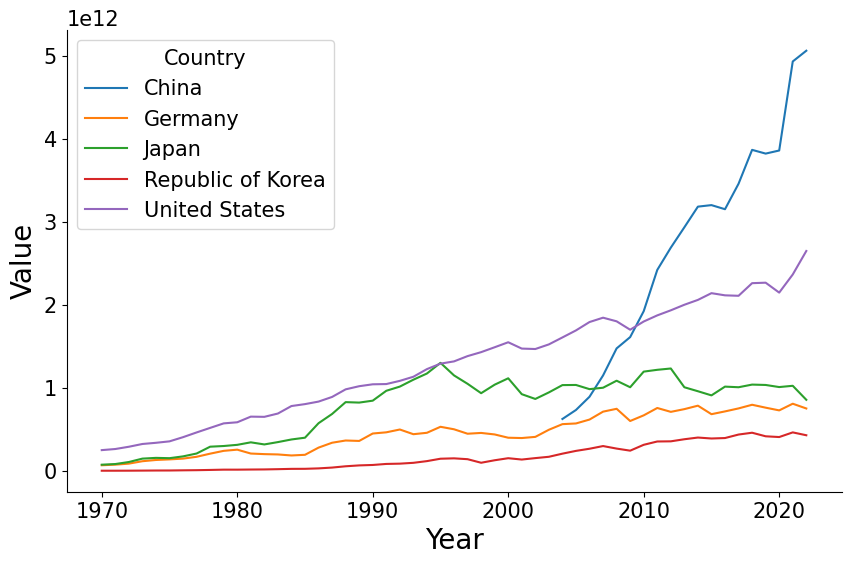

In [9]:
countries = ["United States", "China", "Germany", "Japan", "Republic of Korea"]
selected_countries = manufacturing[manufacturing["Country"].isin(countries)]

sns.lineplot(x="Year", y="Value", data=selected_countries, hue="Country")

/tmp/ipykernel_16185/3943259547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_countries.loc[indices, "Percent of US"] = selected_countries.loc[indices, "Value"].values / selected_countries.loc[selected_countries.Country == "United States", "Value"].values
/tmp/ipykernel_16185/3943259547.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_countries["Percent of US"] *= 100


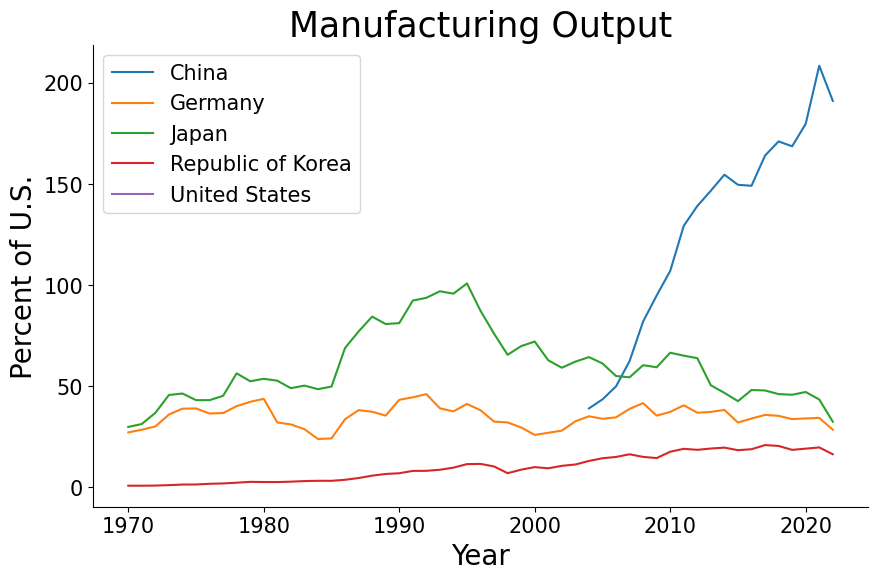

In [10]:
for country in countries[1:]:
    indices = selected_countries.Country == country
    selected_countries.loc[indices, "Percent of US"] = selected_countries.loc[indices, "Value"].values / selected_countries.loc[selected_countries.Country == "United States", "Value"].values

selected_countries["Percent of US"] *= 100
sns.lineplot(x="Year", y="Percent of US", data=selected_countries, hue="Country")
plt.title("Manufacturing Output", fontsize=25)
plt.ylabel("Percent of U.S.")
plt.legend();

plt.savefig("../images/manufacturing_output_percent_of_us.png")

## Occupations
Raw data pulled from [here](https://www.bls.gov/oes/tables.htm)

In [11]:
# all_data = pd.DataFrame()

# for file_name in glob.iglob("../raw_data/business/occupations/*.csv"):
#     data = pd.read_csv(file_name)
#     data = data.rename(columns={"YEAR": "Year", "EMP": "TOT_EMP", "OCC_TIT": "OCC_TITLE"})
#     data["OCC_TITLE"] = data["OCC_TITLE"].str.lower()

#     all_data = pd.concat([all_data, data])

In [12]:
all_data = pd.DataFrame()
for index, file_name in enumerate(sorted(glob.iglob("../raw_data/business/occupations/*nat/national*"))):
    skiprows = {0: 38, 3: 37, 4: 37, 5: 39}.get(index)
        
    data = pd.read_excel(file_name, skiprows=skiprows)
    data = data.rename(columns={column_name: column_name.upper() for column_name in data.columns})
    data = data.rename(columns={"OCC_TITL": "OCC_TITLE", "GROUP": "O_GROUP", "OCC_GROUP": "O_GROUP"})
    
    year_string = file_name.split("national_")[1]
    index = year_string.find("2")
    if index == -1:
        index = year_string.find("1")

    if index == -1:
        continue
    data["Year"] = int(year_string[index:index+4])   
    all_data = pd.concat([all_data, data])

all_data = all_data[~(all_data["TOT_EMP"] == "**") & ~(all_data["TOT_EMP"].isnull()) & ~(all_data["TOT_EMP"] == "#")]
all_data["TOT_EMP"] = all_data["TOT_EMP"].astype(int)
all_data = all_data[
    ~all_data["O_GROUP"].isin(["minor", "major", "broad"])
].reset_index()

In [13]:
job_titles = all_data["OCC_TITLE"].str.lower()
with open("occupation_names.json", "w") as stream:
    json.dump(job_titles.unique().tolist(), stream, indent=4, sort_keys=True)

### Educational administrators 

['Education Administrators, Preschool and Child Care Center/Program'
 'Education Administrators, Elementary and Secondary School'
 'Education Administrators, Postsecondary' 'Education Administrators'
 'Education administrators, preschool and child care center/program'
 'Education administrators, elementary and secondary school'
 'Education administrators, postsecondary'
 'Education administrators, all other'
 'Education Administrators, Preschool and Childcare Center/Program'
 'Education Administrators, All Other'
 'Education and Childcare Administrators, Preschool and Daycare'
 'Education Administrators, Kindergarten through Secondary']


<AxesSubplot:xlabel='Year', ylabel='Percent Change'>

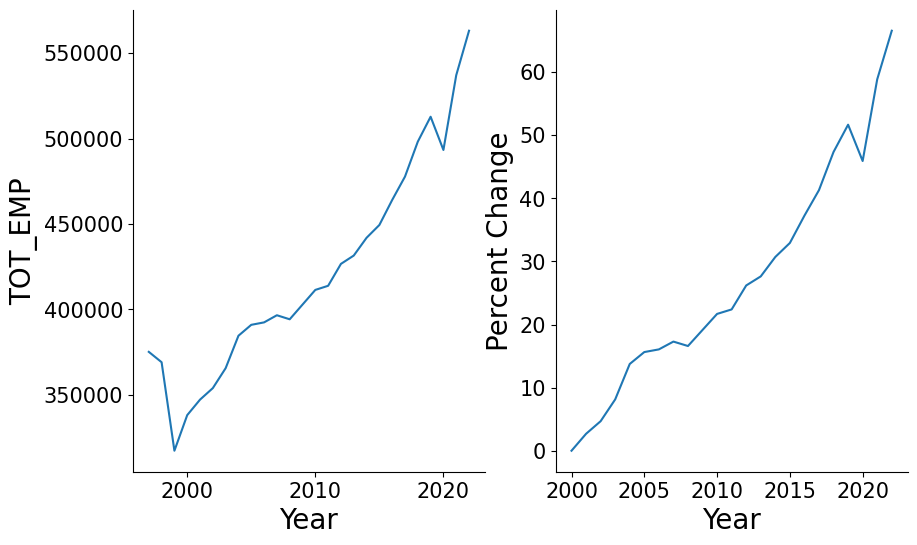

In [14]:
education_administrators = all_data[
    (job_titles.str.contains("education")) &
    (job_titles.str.contains("administrators"))
]
print(education_administrators["OCC_TITLE"].unique())
education_administrators = education_administrators[["Year", "TOT_EMP"]].groupby("Year").sum().reset_index()

plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="TOT_EMP", data=education_administrators)

plt.subplot(1, 2, 2)
education_administrators = helper.percent_change_relative_to(education_administrators, 2000, "TOT_EMP")
sns.lineplot(x="Year", y="Percent Change", data=education_administrators)

### HR Personnel

['Human Resources Managers'
 'Human Resources Assistants, Except Payroll and Timekeeping'
 'Human resources managers, all other'
 'Human resources, training, and labor relations specialists, all other'
 'Human resources assistants, except payroll and timekeeping'
 'Human Resources, Training, and Labor Relations Specialists, All Other*'
 'Human Resources Specialists' 'Human resources managers']


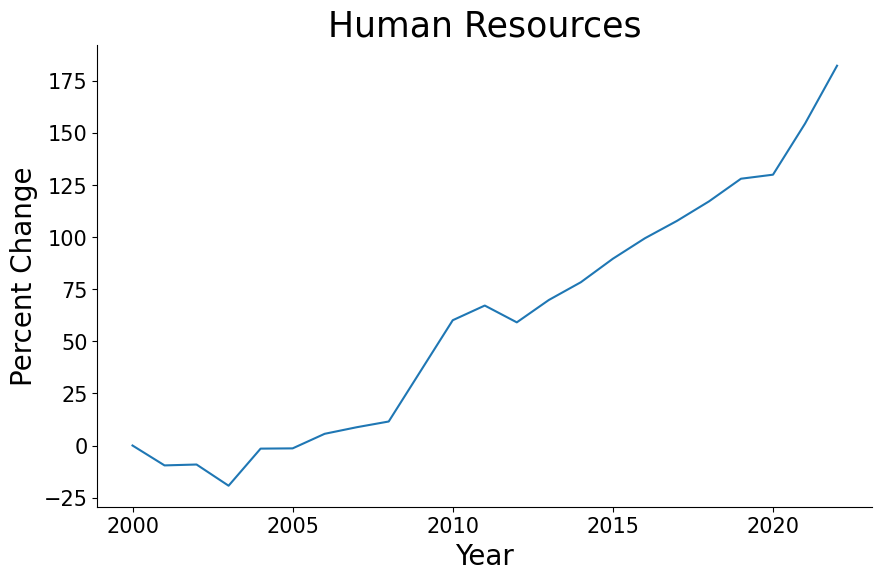

In [15]:
hr_personnel = all_data[
    (job_titles.str.contains("human resources"))
]
print(hr_personnel["OCC_TITLE"].unique())

hr_personnel = hr_personnel[["Year", "TOT_EMP"]].groupby("Year").sum().reset_index()

# plt.subplot(1, 2, 1)
# sns.lineplot(x="Year", y="TOT_EMP", data=hr_personnel)

# plt.subplot(1, 2, 2)
hr_personnel = helper.percent_change_relative_to(hr_personnel, 2000, "TOT_EMP")
sns.lineplot(x="Year", y="Percent Change", data=hr_personnel)
plt.title("Human Resources")

plt.savefig("../images/human_resources.png")

['Tax Examiners, Collectors, and Revenue Agents' 'Tax Preparers'
 'Tax examiners, collectors, and revenue agents' 'Tax preparers'
 'Tax Examiners and Collectors, and Revenue Agents']


<AxesSubplot:xlabel='Year', ylabel='Percent Change'>

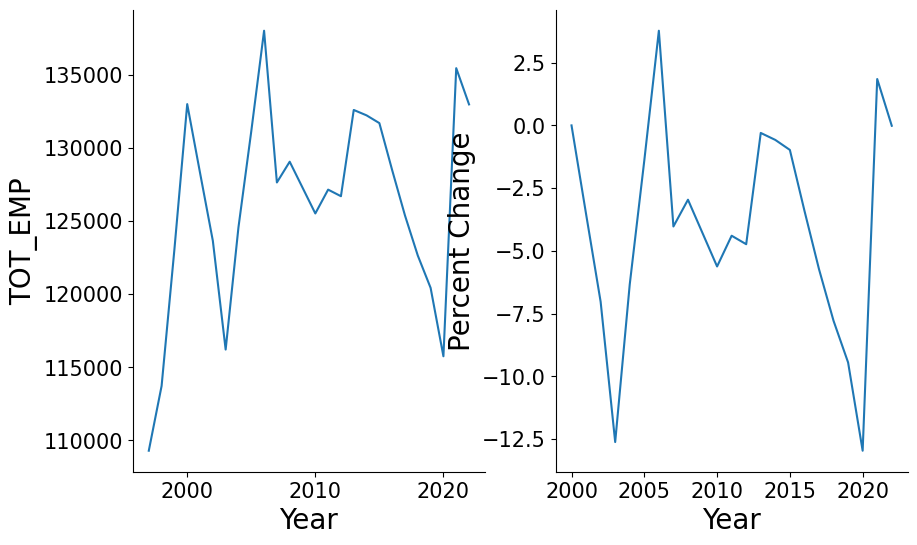

In [16]:
hr_personnel = all_data[
    (job_titles.str.contains("tax "))
]

print(hr_personnel["OCC_TITLE"].unique())

hr_personnel = hr_personnel[["Year", "TOT_EMP"]].groupby("Year").sum().reset_index()

plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="TOT_EMP", data=hr_personnel)

plt.subplot(1, 2, 2)
hr_personnel = helper.percent_change_relative_to(hr_personnel, 2000, "TOT_EMP")
sns.lineplot(x="Year", y="Percent Change", data=hr_personnel)

### Lawyers
Raw data pulled from [here](https://www.abalegalprofile.com/demographics.html)

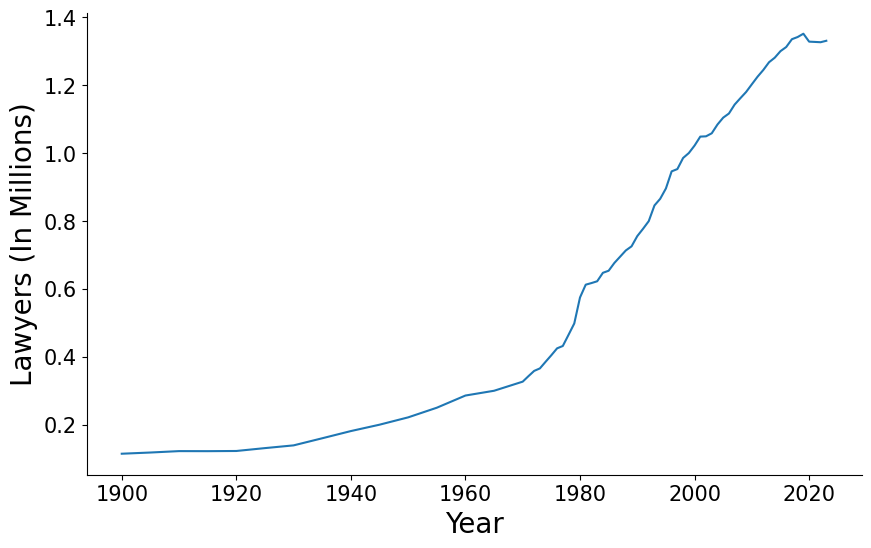

In [17]:
lawyers = pd.read_csv("../raw_data/business/occupations/lawyers.txt").sort_values(by="Year").reset_index(drop=True)
index = lawyers[lawyers.Year == 1900].index[0]
lawyers = lawyers.iloc[index:].reset_index(drop=True)
lawyers["Lawyers"] /= 1_000_000

# plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="Lawyers", data=lawyers)
plt.ylabel("Lawyers (In Millions)")
# plt.subplot(1, 2, 2)
# lawyers = helper.percent_change_relative_to(lawyers, 1970, "Lawyers")
# sns.lineplot(x="Year", y="Percent Change", data=lawyers)

plt.savefig("../images/lawyers.png")

['Lawyers']


<AxesSubplot:xlabel='Year', ylabel='Percent Change'>

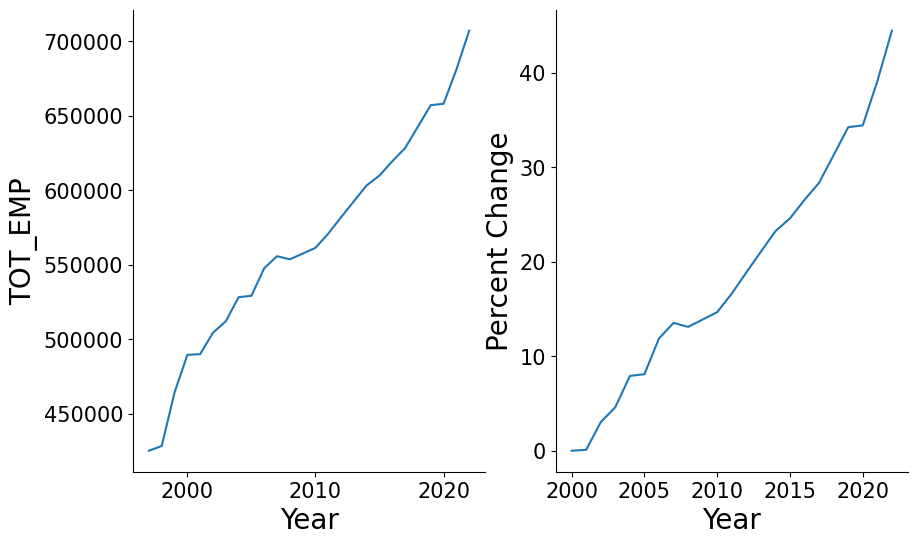

In [18]:
legal = all_data[
    (job_titles.str.contains("lawyers") ) &
    ~(job_titles.str.contains("except legal"))
]
print(legal["OCC_TITLE"].unique())
legal = legal[["Year", "TOT_EMP"]].groupby("Year").sum().reset_index()

plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="TOT_EMP", data=legal)

plt.subplot(1, 2, 2)
legal = helper.percent_change_relative_to(legal, 2000, "TOT_EMP")
sns.lineplot(x="Year", y="Percent Change", data=legal)

### Medical

['Medical Secretaries' 'Medical secretaries'
 'Medical Secretaries and Administrative Assistants']


<AxesSubplot:xlabel='Year', ylabel='Percent Change'>

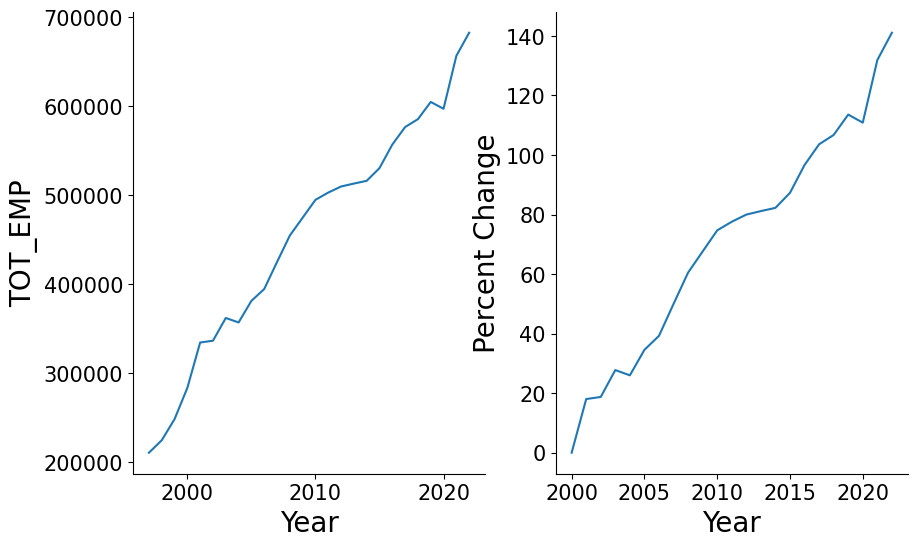

In [19]:
legal = all_data[
    (job_titles.str.contains("medical") | job_titles.str.contains("physician")) &
    (job_titles.str.contains("admin") | job_titles.str.contains("secretaries")) & 
    ~job_titles.str.contains("except")
]
print(legal["OCC_TITLE"].unique())
legal = legal[["Year", "TOT_EMP"]].groupby("Year").sum().reset_index()

plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="TOT_EMP", data=legal)

plt.subplot(1, 2, 2)
legal = helper.percent_change_relative_to(legal, 2000, "TOT_EMP")
sns.lineplot(x="Year", y="Percent Change", data=legal)

['Physicians and Surgeons' 'Physicians and surgeons, all other'
 'Physicians and Surgeons, All Other' 'Family Medicine Physicians'
 'General Internal Medicine Physicians'
 'Physicians, All Other; and Ophthalmologists, Except Pediatric'
 'Emergency Medicine Physicians' 'Physicians, Pathologists'
 'Physicians, All Other']


<AxesSubplot:xlabel='Year', ylabel='Percent Change'>

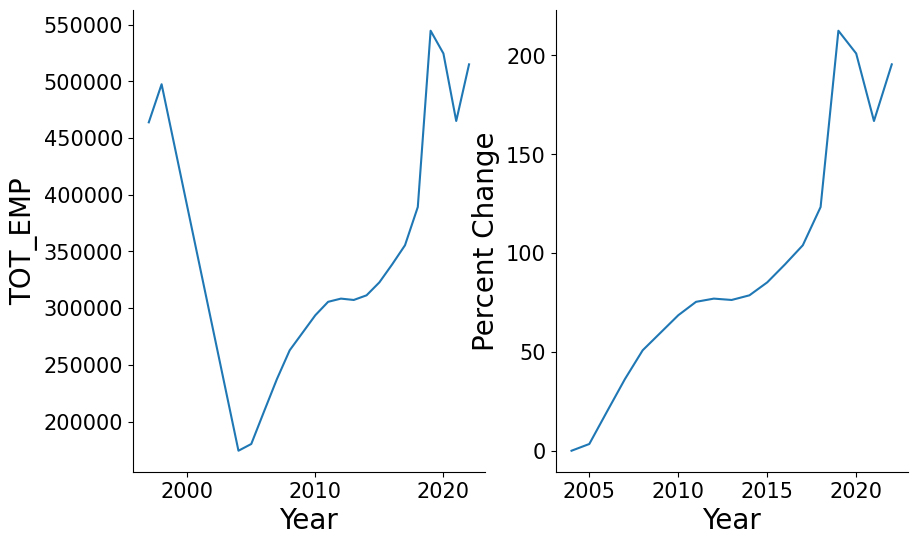

In [20]:
legal = all_data[
    (job_titles.str.contains("physician")) &
    ~job_titles.str.contains("assistants")
]
print(legal["OCC_TITLE"].unique())
legal = legal[["Year", "TOT_EMP"]].groupby("Year").sum().reset_index()

plt.subplot(1, 2, 1)
sns.lineplot(x="Year", y="TOT_EMP", data=legal)

plt.subplot(1, 2, 2)
legal = helper.percent_change_relative_to(legal, 2004, "TOT_EMP")
sns.lineplot(x="Year", y="Percent Change", data=legal)